In [1]:
import os
os.environ["TF_USE_LEGACY_KERAS"] = "1"  # For TF2.16+.
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_gnn as tfgnn
import gzip  
import xml.etree.ElementTree as ET  
from graphviz import Digraph  
from pathlib import Path  
from typing import Tuple , Optional, List
import os  
import re  
import glob  
import tensorflow as tf  

print(f'Running TF-GNN {tfgnn.__version__} with TensorFlow {tf.__version__}.')


Running TF-GNN 1.0.3 with TensorFlow 2.19.0.


In [ ]:
def build_line_graph_tensor(  
    network_path: str,  
    linkstats_path: str,  
    base_linkstats_path: Optional[str] = None  
) -> Tuple[tfgnn.GraphTensor, tf.Tensor]:  
    

     
    opener = gzip.open if network_path.endswith('.gz') else open  
    with opener(network_path, 'rb') as f:  
        tree = ET.parse(f)  
    root = tree.getroot()  

    node_coord = {}  
    for node in root.findall('nodes/node'):  
        nid = node.attrib['id']  
        node_coord[nid] = (float(node.attrib['x']), float(node.attrib['y']))  

    link_list = []  
    for link in root.findall('links/link'):  
        lid = link.attrib['id']  
        frm, to = link.attrib['from'], link.attrib['to']  
        lf    = float(link.attrib.get('length',0.0))  
        fs    = float(link.attrib.get('freespeed',0.0))  
        cap   = float(link.attrib.get('capacity',0.0))  
        pl    = float(link.attrib.get('permlanes',0.0))  
        xf,yf = node_coord[frm]  
        xt,yt = node_coord[to]  
        link_list.append({  
            'id': lid, 'from': frm, 'to': to,  
            'length':lf,'freespeed':fs,'capacity':cap,'permlanes':pl,  
            'xf':xf,'yf':yf,'xt':xt,'yt':yt  
        })  

    link_ids = [lk['id'] for lk in link_list]  
    id2idx = {lid:i for i,lid in enumerate(link_ids)}  
    num_links = len(link_list)  

   
    opener = gzip.open if linkstats_path.endswith('.gz') else open  
    df_ls = pd.read_csv(opener(linkstats_path,'rt'),  
                        sep=r'\s+', engine='python')  
 
    hrs_cols = [c for c in df_ls.columns if c.startswith('HRS') and c.endswith('avg')]  
    
    df_ls = df_ls.set_index('LINK')  
    labels_np = np.zeros((num_links, len(hrs_cols)), dtype=np.float32)  
    for lid, idx in id2idx.items():  
        key = int(lid)  
        if key in df_ls.index:  
            labels_np[idx] = df_ls.loc[key, hrs_cols].values  
        

    labels = tf.constant(labels_np, dtype=tf.float32)  

    
    base_feat_np = None  
    if base_linkstats_path:  
        opener = gzip.open if base_linkstats_path.endswith('.gz') else open  
        df_b = pd.read_csv(opener(base_linkstats_path,'rt'),  
                           sep=r'\s+', engine='python')  
        hrs_b = [c for c in df_b.columns if c.startswith('HRS') and c.endswith('avg')]  
        df_b = df_b.set_index('LINK')  
        base_feat_np = np.zeros((num_links, len(hrs_b)), dtype=np.float32)  
        for lid, idx in id2idx.items():  
            key = int(lid)  
            if key in df_b.index:  
                base_feat_np[idx] = df_b.loc[key, hrs_b].values  
         
        base_feat = tf.constant(base_feat_np, dtype=tf.float32)  
    else:  
        
        base_feat = tf.zeros((num_links, len(hrs_cols)), dtype=tf.float32)  

 
    from_map = {}  
    for i,lk in enumerate(link_list):  
        from_map.setdefault(lk['from'], []).append(i)  

    src, dst = [], []  
    for i,lk in enumerate(link_list):  
        for j in from_map.get(lk['to'], []):  
            src.append(i); dst.append(j)  

    src = tf.constant(src, dtype=tf.int32)  
    dst = tf.constant(dst, dtype=tf.int32)  

   
    node_features = {  
        'length':    tf.constant([[lk['length']]    for lk in link_list], tf.float32),  
        'freespeed': tf.constant([[lk['freespeed']] for lk in link_list], tf.float32),  
        'capacity':  tf.constant([[lk['capacity']]  for lk in link_list], tf.float32),  
        'permlanes': tf.constant([[lk['permlanes']] for lk in link_list], tf.float32),  
        'xf':        tf.constant([[lk['xf']]        for lk in link_list], tf.float32),  
        'yf':        tf.constant([[lk['yf']]        for lk in link_list], tf.float32),  
        'xt':        tf.constant([[lk['xt']]        for lk in link_list], tf.float32),  
        'yt':        tf.constant([[lk['yt']]        for lk in link_list], tf.float32),  
        'base_hrs_avg': base_feat,   
    }  


    adjacency = tfgnn.Adjacency.from_indices(  
                    source=('links', src),  
                    target=('links', dst)  
                )

   
    edge_features = {
        "edge_feat": tf.zeros([adjacency.source.shape[0], 1], dtype=tf.float32)
    }

  
    graph = tfgnn.GraphTensor.from_pieces(  
        node_sets={  
            'links': tfgnn.NodeSet.from_fields(  
                sizes=[num_links],  
                features=node_features  
            )  
        },  
        edge_sets={  
            'line_graph': tfgnn.EdgeSet.from_fields(  
                sizes=[src.shape[0]],  
                adjacency=adjacency,
                features=edge_features  
            )  
        }  
    )  

    return graph, labels  

In [ ]:
def prepare_training_data(dir_path,   
                          network_pattern="network_output*.xml.gz",  
                          ls_pattern="*.linkstats_output*.txt.gz")-> List[Tuple[tfgnn.GraphTensor, tf.Tensor]]:  
    
      
    ls_files = glob.glob(os.path.join(dir_path, ls_pattern))  
    
    base_ls = [f for f in ls_files if f.endswith("linkstats_output_base.txt.gz")]  
    assert len(base_ls)==1, f"Expect exactly one base linkstats, got {base_ls}"  
    base_ls = base_ls[0]  

   
    other_ls = [f for f in ls_files if f!= base_ls]  
     
    rex = re.compile(r"linkstats_output(.+?)\.txt\.gz$")  
    ms = []  
    for fn in other_ls:  
        m = rex.search(fn)  
        if m:  
            ms.append(m.group(1))  
    ms = sorted(ms)    

      
    net_files = glob.glob(os.path.join(dir_path, network_pattern))  
     
    base_net = [f for f in net_files if f.endswith("network_output_base.xml.gz")]  
    if len(base_net)==1:  
        base_net = base_net[0]  
    else:  
        base_net = None  

    
    other_net = {   
       re.search(r"network_output(.+?)\.xml\.gz$", fn).group(1): fn   
       for fn in net_files   
       if fn!= base_net   
         and re.search(r"network_output(.+?)\.xml\.gz$", fn)  
    }  
   

    results = []  
    for m in ms:  
        ls_m = os.path.join(dir_path, f"{os.path.basename(base_ls).split('.')[0]}.linkstats_output{m}.txt.gz")  
        net_m = other_net.get(m)  
        assert net_m, f"Cannot find network_output{m}.xml.gz"  
         
        graph, labels = build_line_graph_tensor(  
            network_path=net_m,  
            linkstats_path=ls_m,  
            base_linkstats_path=base_ls  
        )  
        results.append((graph, labels))  

    return results  



In [10]:
data = prepare_training_data("equil_extracted_train")  
data_val = prepare_training_data("equil_extracted_val")

In [ ]:
def build_dataset(data_tensors:List[Tuple[tfgnn.GraphTensor, tf.Tensor]])->tf.data.Dataset:
  
    example_graph, example_labels = data_tensors[0]  
    graph_spec  = example_graph.spec
    labels_spec = tf.TensorSpec(  
        shape=example_labels.shape,  
        dtype=example_labels.dtype,  
        name="labels"  
    )  
    ds = tf.data.Dataset.from_generator(  
        lambda: ((g, l) for g,l in data_tensors),  
        output_signature=(  
          graph_spec,  
        labels_spec 
        )  
    )

    return ds



In [11]:
ds = build_dataset(data)
ds_val = build_dataset(data_val)

In [ ]:
# Function to build a regression model
def build_regression_model(
    graph_tensor_spec,
    node_dim=64,
    edge_dim=16,
    message_dim=64,
    next_state_dim=64,
    output_dim=3,  # Regression outputs fA, fB, fC
    num_message_passing=3,
    l2_regularization=5e-4,
    dropout_rate=0.2,
    hiden_dim = 64,

):
    input_graph = tf.keras.layers.Input(type_spec=graph_tensor_spec)
    graph = input_graph.merge_batch_to_components()

    # Set initial node state
    def set_initial_node_state(node_set, *, node_set_name):
        try:  
            feat_tensors = list(node_set.features.values())  
            #feat_tensors = [tf.keras.layers.Flatten(k) for k in feat_tensors] 
            print("yes")
        except AttributeError:  
            # Method B: Treat node_set as a Mapping, using keys()/__getitem__.
            feat_tensors = [node_set[k] for k in node_set.keys()]  
            print("no")

         
        features = tf.concat(feat_tensors, axis=-1)  
        print("f = ",features)

        features = tf.keras.layers.Dense(node_dim, activation="relu")(features)
        features = tf.keras.layers.Dense(node_dim, activation="relu")(features)
        features = tf.keras.layers.Dense(node_dim, activation="relu")(features)
     
        return features

         

    def set_initial_edge_state(edge_set, *, edge_set_name):  
        try:  
            feat_tensors = list(edge_set.features.values()) 
            #feat_tensors = [tf.reshape(k,[-1]) for k in feat_tensors] 
            #feat_tensors = [tf.keras.layers.Flatten(k) for k in feat_tensors] 
        except AttributeError:  
            # Method B: Treat edge_set as a Mapping, using keys()/__getitem__
            feat_tensors = [edge_set[k] for k in edge_set.keys()]  
        features = tf.concat(feat_tensors, axis=-1)
        features = tf.keras.layers.Dense(edge_dim, activation="relu")(features)
        return features

    graph = tfgnn.keras.layers.MapFeatures(
        node_sets_fn=set_initial_node_state, edge_sets_fn=set_initial_edge_state
    )(graph)

    # Define helper function for Dense layers with regularization and Dropout.
    def dense(units, activation="relu"):
        regularizer = tf.keras.regularizers.l2(l2_regularization)
        return tf.keras.Sequential([
            tf.keras.layers.Dense(units, activation=activation, kernel_regularizer=regularizer, bias_regularizer=regularizer),
            tf.keras.layers.Dropout(dropout_rate)
        ])

    # GNN core, performing multiple rounds of message passing.
    for i in range(num_message_passing):
        graph = tfgnn.keras.layers.GraphUpdate(
            node_sets={
                "links": tfgnn.keras.layers.NodeSetUpdate(
                    {
                        "line_graph": tfgnn.keras.layers.SimpleConv(
                            message_fn=dense(message_dim),
                            reduce_type="sum",
                            receiver_tag=tfgnn.TARGET
                        )
                    },
                    tfgnn.keras.layers.NextStateFromConcat(dense(next_state_dim))
                )
            }
        )(graph)


    node_states = tfgnn.keras.layers.Readout(node_set_name="links")(graph)


    print(node_states)
    print("shape=",node_states.shape[0])
    print("shape=",node_states.shape[1])
    res = tf.expand_dims(node_states, axis=1) # [batch_size*num_nodes, 1, next_state_dim]
    def unflatten(x):
        return tf.reshape(x,[-1,node_states.shape[0],next_state_dim]) # [batch_size, num_nodes, next_state_dim]
    res = tf.keras.layers.Lambda(unflatten)(res)
    res = tf.keras.layers.Dense(hiden_dim,activation='relu')(res)
    res = tf.keras.layers.Dense(hiden_dim,activation='relu')(res)
    res = tf.keras.layers.Dense(hiden_dim,activation='relu')(res)
    res = tf.keras.layers.Dense(output_dim)(res)


    return tf.keras.Model(inputs=[input_graph], outputs=[res])

In [13]:
train_dataset = ds
batch_size = 32
train_ds_batched = train_dataset.shuffle(buffer_size=3).batch(batch_size=batch_size).repeat()


In [ ]:
# Get model input and label specifications
model_input_graph_spec, label_spec = train_dataset.element_spec
del label_spec  # Delete unused tag specifications

# Build model
model = build_regression_model(
    graph_tensor_spec=model_input_graph_spec,
    node_dim=128,
    edge_dim=64,
    message_dim=128,
    next_state_dim=128,
    output_dim=25,  # Regression outputs 
    num_message_passing=3,
    l2_regularization=5e-5,
    dropout_rate=0.01, )

# Compile model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss=tf.keras.losses.MeanSquaredError(),
    metrics=[
        tf.keras.metrics.MeanAbsoluteError(),
        tf.keras.metrics.RootMeanSquaredError()
    ]
)

# Print model structure
model.summary()

yes
f =  KerasTensor(type_spec=TensorSpec(shape=(23, 33), dtype=tf.float32, name=None), name='tf.concat_2/concat:0', description="created by layer 'tf.concat_2'")
KerasTensor(type_spec=TensorSpec(shape=(23, 128), dtype=tf.float32, name=None), name='Placeholder_5:0', description="created by layer 'readout_2'")
shape= 23
shape= 128
Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [()]                      0         
                                                                 
 input.merge_batch_to_compo  ()                        0         
 nents_2 (InstanceMethod)                                        
                                                                 
 map_features_2 (MapFeature  ()                        37504     
 s)                                                              
                                                         

In [21]:
# Train model
#history = model.fit(train_dataset,epochs=10)
history = model.fit(train_ds_batched, steps_per_epoch=10,epochs=500,validation_data=ds_val)

Epoch 1/500
10/10 [==============================] - 7s 171ms/step - loss: 1803869.1250 - mean_absolute_error: 358.1912 - root_mean_squared_error: 1343.0819 - val_loss: 246741.3750 - val_mean_absolute_error: 181.5367 - val_root_mean_squared_error: 496.7307
Epoch 2/500
10/10 [==============================] - 0s 50ms/step - loss: 254009.7188 - mean_absolute_error: 171.6678 - root_mean_squared_error: 503.9937 - val_loss: 70580.0625 - val_mean_absolute_error: 106.4464 - val_root_mean_squared_error: 265.6690
Epoch 3/500
10/10 [==============================] - 1s 75ms/step - loss: 102355.7812 - mean_absolute_error: 113.0781 - root_mean_squared_error: 319.9308 - val_loss: 41821.6406 - val_mean_absolute_error: 79.1624 - val_root_mean_squared_error: 204.5033
Epoch 4/500
10/10 [==============================] - 1s 112ms/step - loss: 58002.3164 - mean_absolute_error: 88.1579 - root_mean_squared_error: 240.8366 - val_loss: 23114.8691 - val_mean_absolute_error: 62.6665 - val_root_mean_squared_err

In [ ]:
tf.saved_model.save(model, "my_saved_model_2") 

c:\Users\ke\AppData\Local\anaconda3\envs\tfgnn\lib\site-packages\tensorflow\python\saved_model\nested_structure_coder.py:458: UserWarning: Encoding a StructuredValue with type tensorflow_gnn.GraphTensorSpec; loading this StructuredValue will require that this type be imported and registered.
  warnings.warn("Encoding a StructuredValue with type %s; loading this "
c:\Users\ke\AppData\Local\anaconda3\envs\tfgnn\lib\site-packages\tensorflow\python\saved_model\nested_structure_coder.py:458: UserWarning: Encoding a StructuredValue with type tensorflow_gnn.ContextSpec.v2; loading this StructuredValue will require that this type be imported and registered.
  warnings.warn("Encoding a StructuredValue with type %s; loading this "
c:\Users\ke\AppData\Local\anaconda3\envs\tfgnn\lib\site-packages\tensorflow\python\saved_model\nested_structure_coder.py:458: UserWarning: Encoding a StructuredValue with type tensorflow_gnn.NodeSetSpec; loading this StructuredValue will require that this type be impor

INFO:tensorflow:Assets written to: my_saved_model\assets


INFO:tensorflow:Assets written to: my_saved_model\assets


In [33]:
val_ds = ds_val

In [44]:
predict_graphs = []
actual_labels = []

# Generate prediction
for graph, labels in val_ds:
    predict_graph = model(graph)  # Prediction
    predict_graphs.append(predict_graph.numpy())  # Save prediction results
    actual_labels.append([labels.numpy()])  # Save actual labels

# Convert to NumPy array
predict_graphs = np.concatenate(predict_graphs, axis=0)
actual_labels = np.concatenate(actual_labels, axis=0)

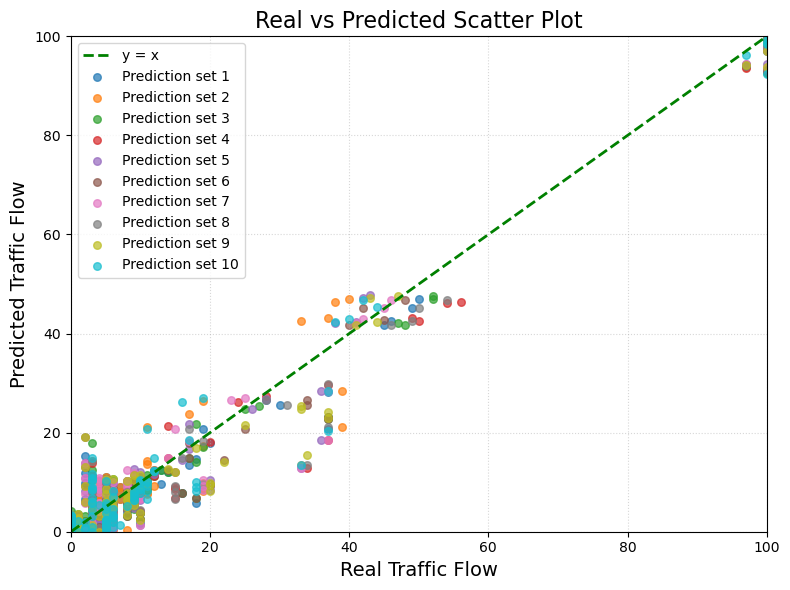

In [ ]:
fig = plt.figure(figsize=(8, 6))  

 
plt.plot([0, 100], [0, 100],  
         linestyle='--',       
         color='green',  
         linewidth=2,  
         label='y = x')  

 
for j in range(len(predict_graphs)):  
    x = actual_labels[j]  
    y = predict_graphs[j]  
    plt.scatter(  
        x, y,  
        c='C{}'.format(j),     
        s=30,  
        alpha=0.7,  
        label=f'Prediction set {j+1}'  
    )  

plt.xlabel('Real Traffic Flow', fontsize=14)  
plt.ylabel('Predicted Traffic Flow', fontsize=14)  
plt.title('Real vs Predicted Scatter Plot', fontsize=16)  
plt.grid(True, linestyle=':', alpha=0.5)  
plt.legend(loc='upper left')    
plt.xlim(0, 100)  
plt.ylim(0, 100)  

plt.tight_layout()  
plt.show() 

In [37]:
tf.saved_model.save(model, "my_saved_model_2") 
import json  

with open("train_history_2.json", "w") as f:  
    json.dump(history.history, f)

c:\Users\ke\AppData\Local\anaconda3\envs\tfgnn\lib\site-packages\tensorflow\python\saved_model\nested_structure_coder.py:458: UserWarning: Encoding a StructuredValue with type tensorflow_gnn.GraphTensorSpec; loading this StructuredValue will require that this type be imported and registered.
  warnings.warn("Encoding a StructuredValue with type %s; loading this "
c:\Users\ke\AppData\Local\anaconda3\envs\tfgnn\lib\site-packages\tensorflow\python\saved_model\nested_structure_coder.py:458: UserWarning: Encoding a StructuredValue with type tensorflow_gnn.ContextSpec.v2; loading this StructuredValue will require that this type be imported and registered.
  warnings.warn("Encoding a StructuredValue with type %s; loading this "
c:\Users\ke\AppData\Local\anaconda3\envs\tfgnn\lib\site-packages\tensorflow\python\saved_model\nested_structure_coder.py:458: UserWarning: Encoding a StructuredValue with type tensorflow_gnn.NodeSetSpec; loading this StructuredValue will require that this type be impor

INFO:tensorflow:Assets written to: my_saved_model_2\assets


INFO:tensorflow:Assets written to: my_saved_model_2\assets


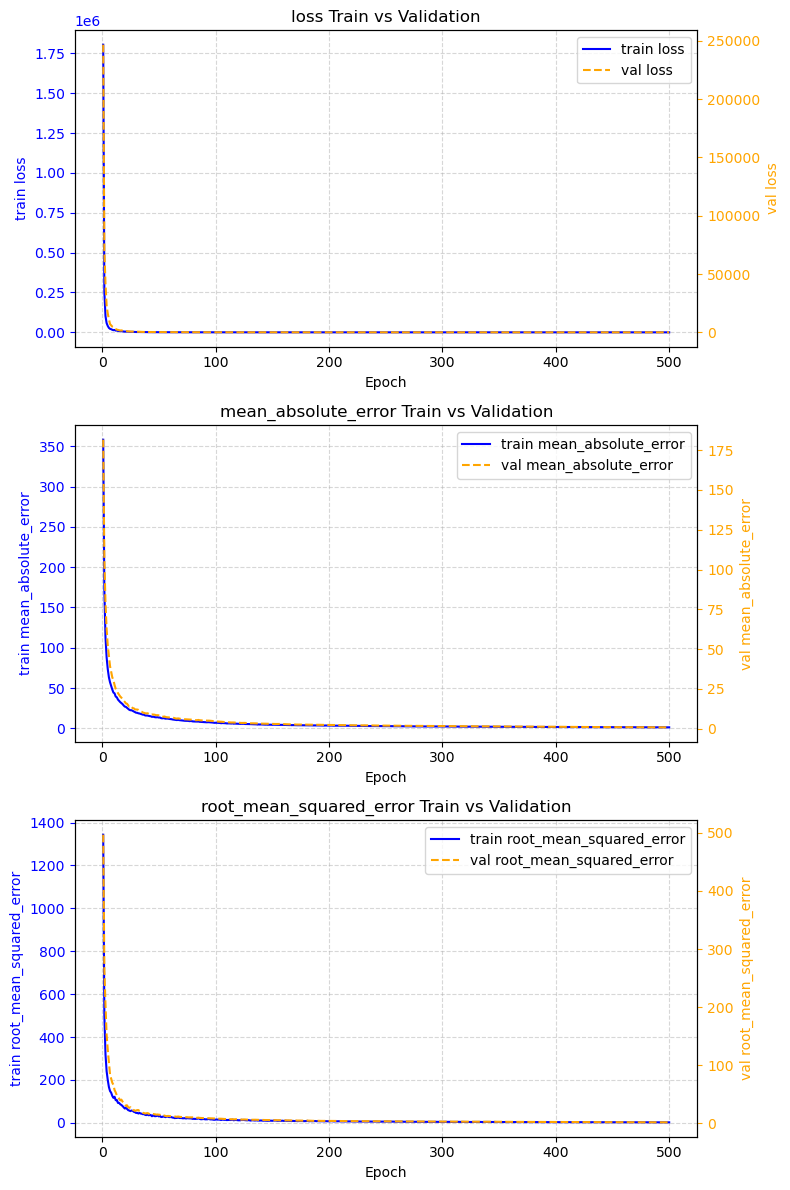

In [42]:
metrics = [m for m in history.history if not m.startswith("val_")]  
n = len(metrics)  

fig, axes = plt.subplots(n, 1, figsize=(8, 4 * n), squeeze=False)  
for i, metric in enumerate(metrics):  
    val_metric = f"val_{metric}"  
    if val_metric not in history.history:  
        continue  

    epochs = range(1, len(history.history[metric]) + 1)  
    ax1 = axes[i, 0]  
    ax2 = ax1.twinx()  

    # train  
    ax1.plot(epochs, history.history[metric],  
             color='blue',  label=f"train {metric}")  
    ax1.set_ylabel(f"train {metric}", color='blue')  
    ax1.tick_params(axis='y', colors='blue')  

    # val  
    ax2.plot(epochs, history.history[val_metric],  
             color='orange',  label=f"val {metric}",linestyle="--")  
    ax2.set_ylabel(f"val {metric}", color='orange')  
    ax2.tick_params(axis='y', colors='orange')  

     
    ax1.set_xlabel("Epoch")  
    ax1.grid(True, linestyle="--", alpha=0.5)  
    lines = ax1.get_lines() + ax2.get_lines()  
    labels = [l.get_label() for l in lines]  
    ax1.legend(lines, labels, loc="best")  
    ax1.set_title(f"{metric} Train vs Validation")  

plt.tight_layout()  
plt.show()

In [45]:
dls = []
for dg in data:
    dls.append(np.array(dg[1][:,-1]).flatten())
dls_val = []
for dg in data_val:
    dls_val.append(np.array(dg[1][:,-1]).flatten())
print(len(dls))
print(len(dls_val))

40
10


In [46]:
array_dl = np.array(dls).flatten()
array_dl_val = np.array(dls_val).flatten()
print(len(array_dl))
print(len(array_dl_val))

920
230


In [48]:
print(np.max(array_dl))
print(np.max(array_dl_val))

100.0
100.0


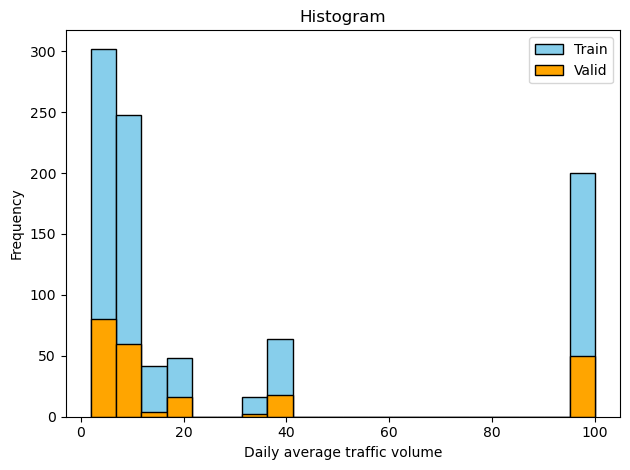

In [49]:
plt.hist(array_dl, bins=20, color='skyblue', edgecolor='black',label='Train')
plt.hist(array_dl_val, bins=20, color='orange', edgecolor='black',label='Valid')   
plt.legend()
plt.title('Histogram')  
plt.xlabel('Daily average traffic volume')  
plt.ylabel('Frequency')  

plt.tight_layout()   
plt.show()  